**Task:** Compare Oakland A's spend efficiently to determine performance deviation during 2000-'05 period. 

In [1]:
import sqlite3
import pandas as pd
import numpy as np

from scipy.stats import norm
from scipy import stats

sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)

salary_query = "SELECT yearID, sum(salary) as total_payroll FROM Salaries WHERE lgID == 'AL' GROUP BY yearID"

team_salaries = pd.read_sql(salary_query, conn)
team_salaries.head()

,yearID,total_payroll
0,1985,134401120.0
1,1986,157716444.0
2,1987,136088747.0
3,1988,157049812.0
4,1989,188771688.0


In [2]:
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix

import seaborn as sns

In [3]:
%load_ext sql
#%reload_ext sql
%matplotlib inline

## Part 1: Wrangling
#### Problem 1

load data

In [4]:
%sql sqlite:///lahman2014.sqlite SELECT * FROM Pitching

Done.


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [5]:
salaries = %%sql SELECT * FROM Salaries;
Salaries = salaries.DataFrame().set_index(['yearID', 'teamID'])

teams = %%sql SELECT * FROM Teams
Teams = teams.DataFrame().set_index(['yearID', 'teamID'])

Done.
Done.


total payroll & winning percentage (number of wins / number of games * 100) for each team (that is, for each teamID and yearID combination)

In [6]:
%%sql 
SELECT t1.yearID || '_' || t1.teamID as 'rowID', t2.franchID, t2.W W, t2.G G, 
       SUM(t1.salary) 'Team Year Expense', (W*100/G) as 'W/G %'
FROM Salaries t1
LEFT JOIN Teams t2
  ON t1.yearID = t2.yearID 
  AND t1.teamID = t2.teamID 
GROUP BY 
  t2.rowID 
ORder By rowID
LIMIT 5;

Done.


rowID,franchID,W,G,Team Year Expense,W/G %
1985_ATL,ATL,66,162,14807000.0,40
1985_BAL,BAL,83,161,11560712.0,51
1985_BOS,BOS,81,163,10897560.0,49
1985_CAL,ANA,90,162,14427894.0,55
1985_CHA,CHW,85,163,9846178.0,52


**My join:** dropping 143 years, where much of team historical performance history is lost, but the remainder can be correlated to teams' salary expense. Here's a summary of the resulting data:  
-**Years**: accounting for 1985 to 2014 (29 out of 143)    
-**Teams**: accounting for 116 out of 151   
-**playerID**: accounting for spend per player abstracting away from distribution 

**Missing data:** Salaries starts its records in 1985, after Teams. Data from the last 29 years should suffice for our analysis of events transpiring in years 2000 - 2005.   

**SQL code**  
SELECT t1.yearID || '_' || t1.teamID AS 'rowID', t2.franchID, t2.W W, t2.G G,   
...     SUM(t1.salary) 'Team Year Expense', (W*100/G) AS 'W/G %'  
FROM Salaries t1  
LEFT JOIN Teams t2  
...  ON t1.yearID = t2.yearID   
...  AND t1.teamID = t2.teamID  
GROUP BY  
...  t2.rowID   
ORDER BY rowID  

## Part 2: Exploratory Data Analysis
#### Problem 2

*plot: payroll dist. accross teams (t =[1990 - 2014])*

**code description:** 2 scatter plots of yearly team salaries with boxplot overlay.

## Teams

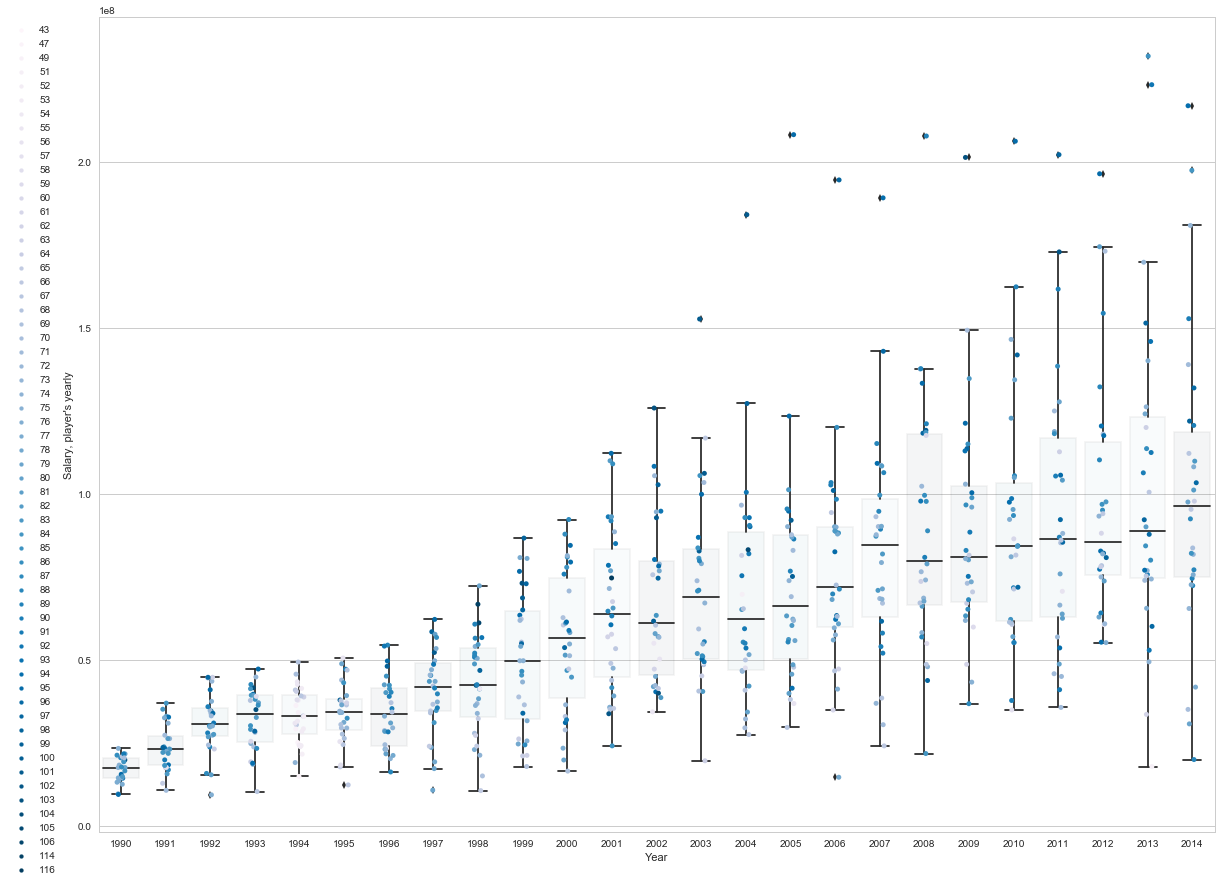

In [420]:
sns.set_style("whitegrid")

t1,t2 = 1990, 2014
sls = Salaries.loc[t1:t2].groupby([ 'yearID', 'teamID']).sum().reset_index()
sls = sls.merge(Teams.W.reset_index()) #sls.merge(wns)

dims = (20, 15)
fig, ax = plt.subplots(figsize= dims)
g= sns.stripplot(x="yearID", y="salary", hue='W',  palette="PuBu",jitter =True, data=sls)
g= sns.boxplot(x="yearID", y="salary", palette=sns.color_palette("PuBuGn_d"), data=sls)
ax.legend(bbox_to_anchor=(-.03, 1), markerscale = .5)
plt.setp(ax.artists, alpha=.05)
g.set(xlabel='Year', 
       ylabel='Salary, player\'s yearly')
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 1))

plt.savefig('problem2.pdf', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None)

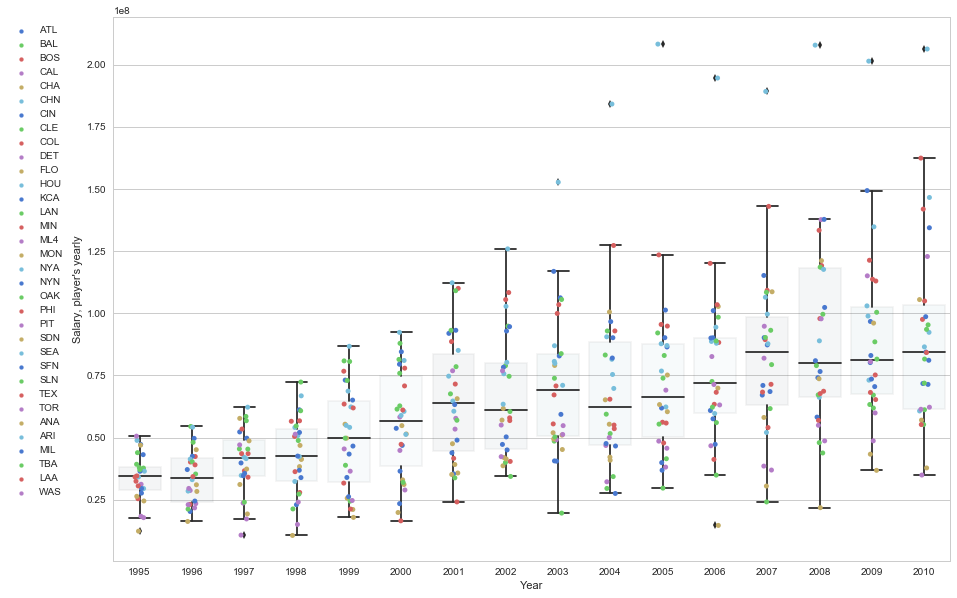

In [419]:
t1,t2 = 1995, 2010
sls = Salaries.loc[t1:t2].groupby([ 'yearID', 'teamID']).sum().reset_index()

dims = (15, 10)
fig2, ax2 = plt.subplots(figsize= dims)
sns.set_style("whitegrid")
g = sns.stripplot(x="yearID", y="salary", hue='teamID',  palette="muted",jitter =True, data=sls)
g = sns.boxplot(x="yearID", y="salary", palette=sns.color_palette("PuBuGn_d"), data=sls)
plt.legend(bbox_to_anchor=(-.05, 1), markerscale = .5)
plt.setp(ax2.artists, alpha=.05)
g.set(xlabel='Year', 
       ylabel='Salary, player\'s yearly')
for patch in ax2.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 1))

## Players

#### Q1: What statements can you make about the distribution of payrolls conditioned on time based on these plots? Remember you can make statements in terms of central tendency, spread, etc.

**A:** The first scatter graphs plot salaries each team paid their players 1990-2015. The scatterplots of this non-normalized data don't seem to indicate a clear pattern of higher salaried teams consistently having highest number of wins, but show a fair amount of variance in salary distribution.

Rare talent is worth considerably more. Players with unique talent may carry a high impact on winning percentage. 

Thus potentially, discovering star baseball players could carry high impact on winning. Most teams' total paid salaries fall within 2SD of the mean yearly; only a few teams fell outside the 2nd SD, starting in 2003.  Player salaries are skewed heavier and trail, i.e. average player's salary ($mil) is 1.9, highest paid player's salary is 33 for several consecutive years. Both team and player salary distributions are right skewed. 

Correlation between payroll and winning percentage:  
Team Salaries--->  Player Runs---->  Game Wins

#### Problem 3
​
Write code to produce plots that specifically show at least one of the statements you made in Question 1. For example, if you make a statement that there is a trend for payrolls to decrease over time, make a plot of a statistic for central tendency (e.g., mean payroll) vs. time to show that specficially.

**code description:** 2 histograms and a scatter plot indicating central tendency and hilighting outliers. 

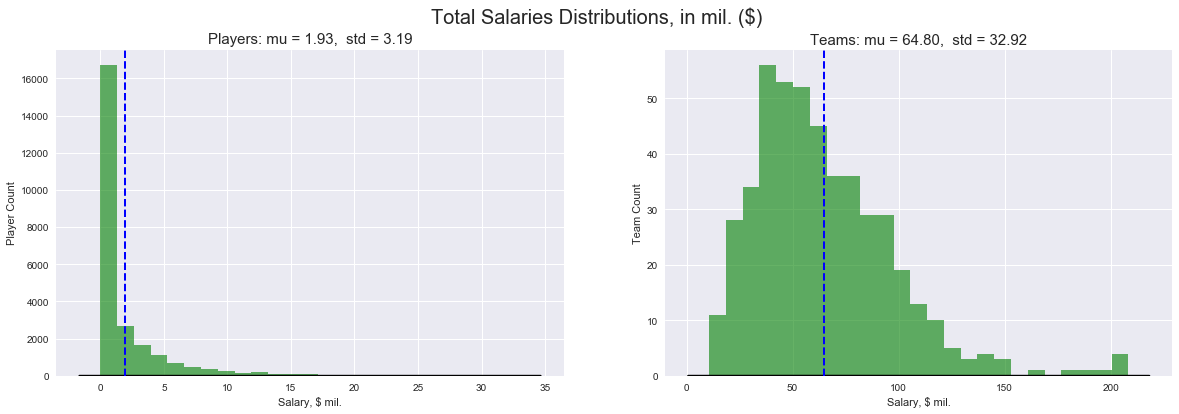

In [413]:
psal_data = Salaries.salary/1e6
tmsal_data = sls.salary/1e6

fig = plt.figure(figsize=[20,6])
fig.suptitle('Total Salaries Distributions, in mil. ($)',fontsize=20)

#Team Salaries
fig.add_subplot(121)
mu, std = norm.fit(psal_data)

plt.hist(psal_data, bins=25, normed=False, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.axvline(psal_data.mean(), color='b', linestyle='dashed', linewidth=2)
title = "Players: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title, fontsize=15)
plt.xlabel('Salary, $ mil.')
plt.ylabel('Player Count')

#Player Salaries
fig.add_subplot(122)
mu, std = norm.fit(tmsal_data)

plt.hist(tmsal_data, bins=25, normed=False, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.axvline(tmsal_data.mean(), color='b', linestyle='dashed', linewidth=2)
title = "Teams: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title, fontsize=15)
plt.xlabel('Salary, $ mil.')
plt.ylabel('Team Count')

plt.show()

### Player performance vs Salary

In [12]:
#player 'performance' dfs
Batting = pd.read_csv('Batting.csv')
Pitching = pd.read_csv('Pitching.csv')
Fielding = pd.read_csv('fielding.csv')

In [13]:
Player = Salaries[['playerID','salary']].reset_index().sort_values('salary', ascending=False).set_index(['playerID', 'yearID'])

batting = Batting.set_index(['playerID', 'yearID'])[['R','G']].sort_values('R', ascending=False).dropna()
batting['Rg'] = batting.R/batting.G
batting = batting[['Rg', 'R', 'G']].sort_values('Rg', ascending=False).dropna()
batting = batting.query('yearID >= 1990 & yearID <= 2014')
player = pd.merge(Player.reset_index(), batting.reset_index(),on=['playerID','yearID'], how='inner')\
               .set_index(['playerID','yearID'])

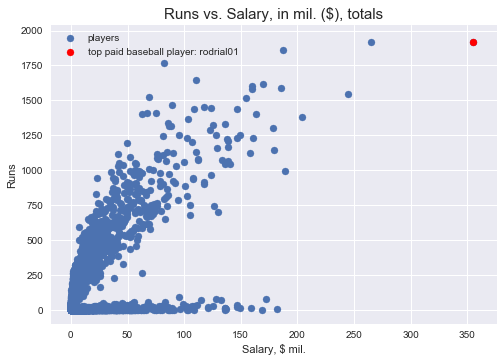

teamID      salary        Rg      R    G
playerID  yearID                                         
rodrial01 2010      NYA  33000000.0  0.540146   74.0  137
          2009      NYA  33000000.0  0.629032   78.0  124
          2011      NYA  32000000.0  0.676768   67.0   99
          2012      NYA  30000000.0  0.606557   74.0  122
          2013      NYA  29000000.0  0.477273   21.0   44
          2008      NYA  28000000.0  0.753623  104.0  138
wellsve01 2011      LAA  26187500.0  0.458015   60.0  131
rodrial01 2005      NYA  26000000.0  0.765432  124.0  162

In [407]:
sns.set()

players_df = player.groupby('playerID').sum().reset_index().sort_values('salary', ascending=False)
players_df.salary = players_df.salary/1e6

plt.scatter(players_df.salary,players_df.R,
           label='players')
plt.scatter(players_df[players_df.playerID == 'rodrial01'].salary,
            players_df[players_df.playerID == 'rodrial01'].R,
           color='red', label='top paid baseball player: rodrial01')
title = "Runs vs. Salary, in mil. ($), totals"
plt.title(title, fontsize=15)

plt.legend(loc='upper left', frameon=False)

plt.xlabel('Salary, $ mil.')
plt.ylabel('Runs')
plt.show()

player.head(8)

### Correlation between payroll and winning percentage
#### Problem 4  
Write code to discretize year into five time periods (you can use [pandas.cut](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html) to accomplish this) and then make a scatterplot showing mean winning percentage (y-axis) vs. mean payroll (x-axis) for each of the five time periods. You could add a regression line (using, e.g., NumPy's [polyfit](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html)) in each scatter plot to ease interpretation.

**code description:** discretized salary data and plotted winning percentages vs mean payrolls. 

In [15]:
# Tables: 
#team_wins
#player
#team_wins
#wns

pd.cut(): 
    years = year cut into 5

scatterplot(): 
    for years in year:
        mean W% (y-axis)
        mean payroll (x-axis)
        polyfit 
    return scatterplot

In [16]:
#combine Team (wins) with player (salaries & performance) data into a roster dataframe
team_wins = pd.DataFrame(Teams.W /Teams.G, columns=['wns']).join(Teams.W).join(Teams.G).query('yearID >= 1990 & yearID <= 2014')
team_wins.reset_index()

roster = player.reset_index().merge(team_wins.reset_index(), 
                           on=['yearID','teamID'], 
                           suffixes=('_player','_team'))\
      .set_index(['yearID','teamID', 'playerID'])
roster.columns = ['salary', 'RG', 'R', 'G', 'WG_team', 'W_team', 'G_team']
roster.head(4)

salary        RG      R    G  WG_team  W_team  \
yearID teamID playerID                                                       
2010   NYA    rodrial01  33000000.0  0.540146   74.0  137  0.58642      95   
              sabatcc01  24285714.0  0.000000    0.0   34  0.58642      95   
              jeterde01  22600000.0  0.707006  111.0  157  0.58642      95   
              teixema01  20625000.0  0.715190  113.0  158  0.58642      95   

                         G_team  
yearID teamID playerID           
2010   NYA    rodrial01     162  
              sabatcc01     162  
              jeterde01     162  
              teixema01     162

In [17]:
def discretize(df, n_bins = 5):
    '''discretize year into five time periods'''
    yr = df.reset_index().yearID
    hist, bin_edges = np.histogram(yr.values,n_bins)
    bin_edges = np.round_(bin_edges).astype(int)
    
    mag_bins = pd.cut(df.reset_index().yearID, bin_edges)
    cut_df = df.reset_index().groupby(mag_bins).mean()

    return cut_df

discretize(roster, n_bins = 5)

,yearID,salary,RG,R,G,WG_team,W_team,G_team
yearID,,,,,,,,
"(1990, 1995]",1993.182073,1.006479e+06,0.268655,24.484034,66.063585,0.498426,73.844258,148.126050
"(1995, 2000]",1998.061597,1.438055e+06,0.247404,24.205820,65.310323,0.496008,80.330501,161.943925
"(2000, 2004]",2002.485043,2.421534e+06,0.226550,23.429969,66.116858,0.496917,80.446464,161.886777
"(2004, 2009]",2006.994169,2.999449e+06,0.221117,23.054945,65.745683,0.498030,80.677282,161.986544
"(2009, 2014]",2011.978777,3.596344e+06,0.205291,20.513921,64.815838,0.498196,80.707668,161.998403


make a scatterplot showing: 
- mean winning percentage (y-axis) vs. mean payroll (x-axis) (for each of the five time periods)

In [18]:
n_bins=5

yr = roster.reset_index().yearID
hist, bin_edges = np.histogram(yr.values,n_bins)
bin_edges = np.round_(bin_edges).astype(int)

mag_bins = pd.cut(roster.reset_index().yearID, bin_edges)
cut_df = roster.reset_index().groupby([mag_bins,'teamID','playerID']).mean().dropna()
cut_df.columns = ['yearID_avg', 'salary', 'RG', 'R', 'G', 'WG_team', 'W_team', 'G_team']
cut_df = cut_df.reset_index()

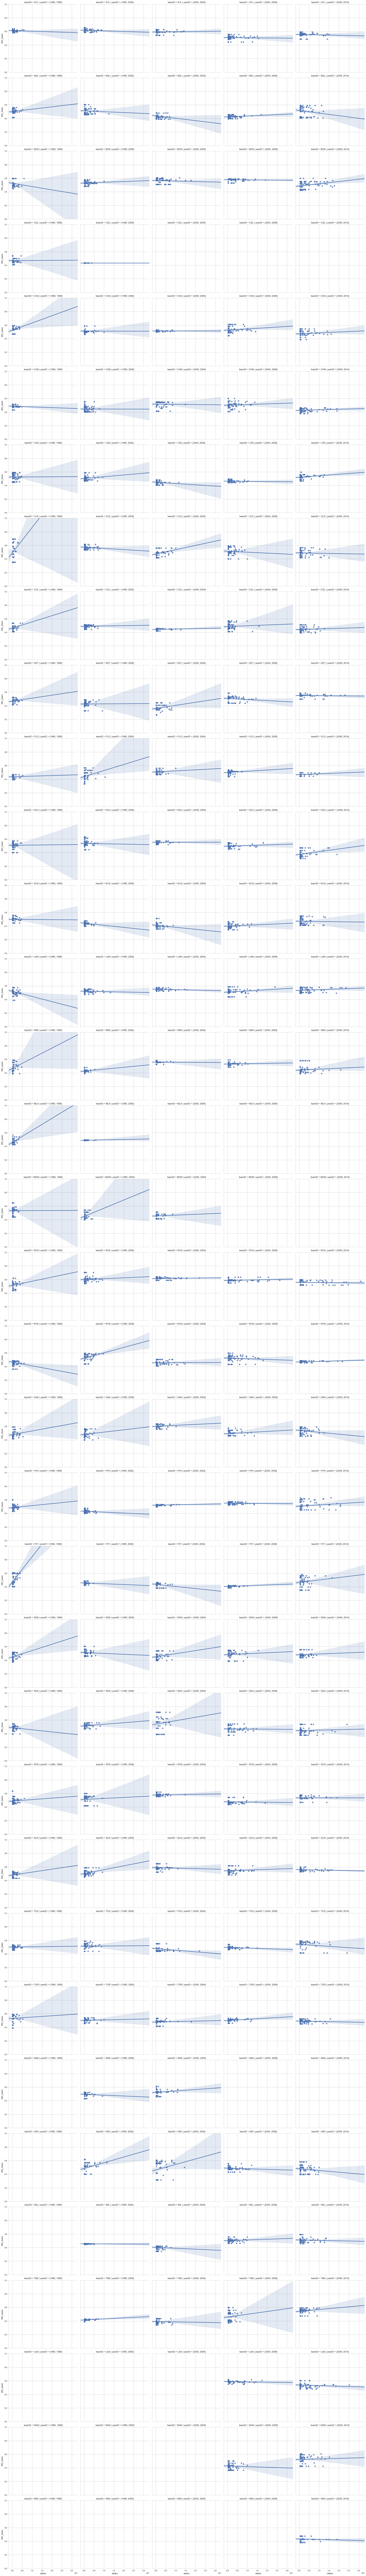

In [465]:
g = sns.lmplot('salary', 'WG_team', data=cut_df, row='teamID', col='yearID')
g.set(ylim=(0, 1))

#### Q2: What can you say about team payrolls across these periods? Are there any teams that standout as being particularly good at paying for wins across these time periods? What can you say about the Oakland A's spending efficiency across these time periods (labeling points in the scatterplot can help interpretation).
**A:** Player Runs vs Salary and Team Wins vs Salary plots below show an increasing spread over the selected time periods. 

2000-'05: OAK's win rate had the highest bias and higher runs to spend ratio than average across all teams. 

1990-'14: OAK's efficiency decreased over time. 

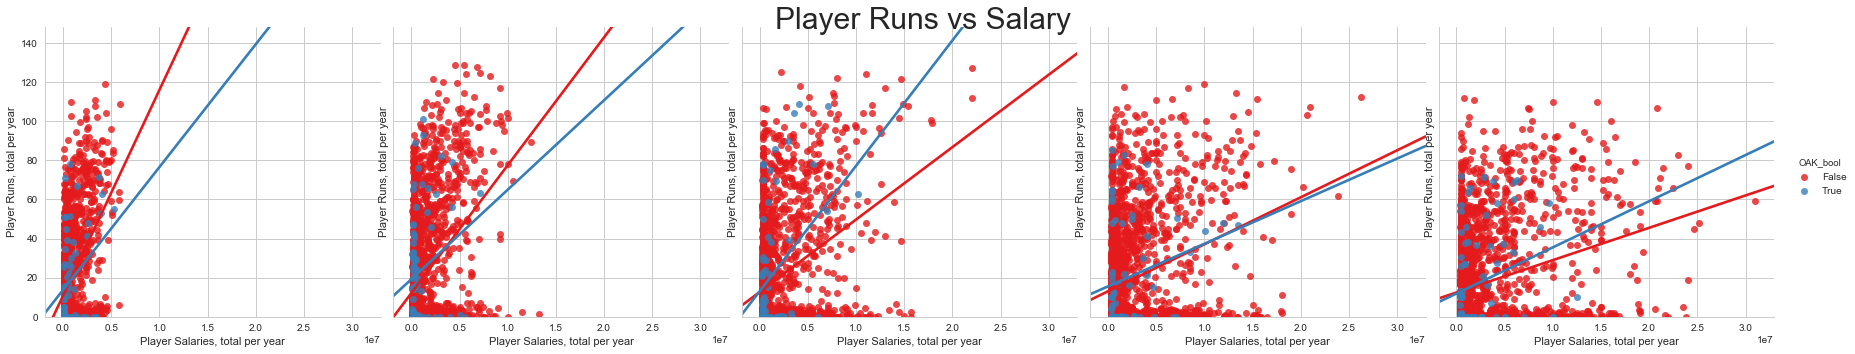

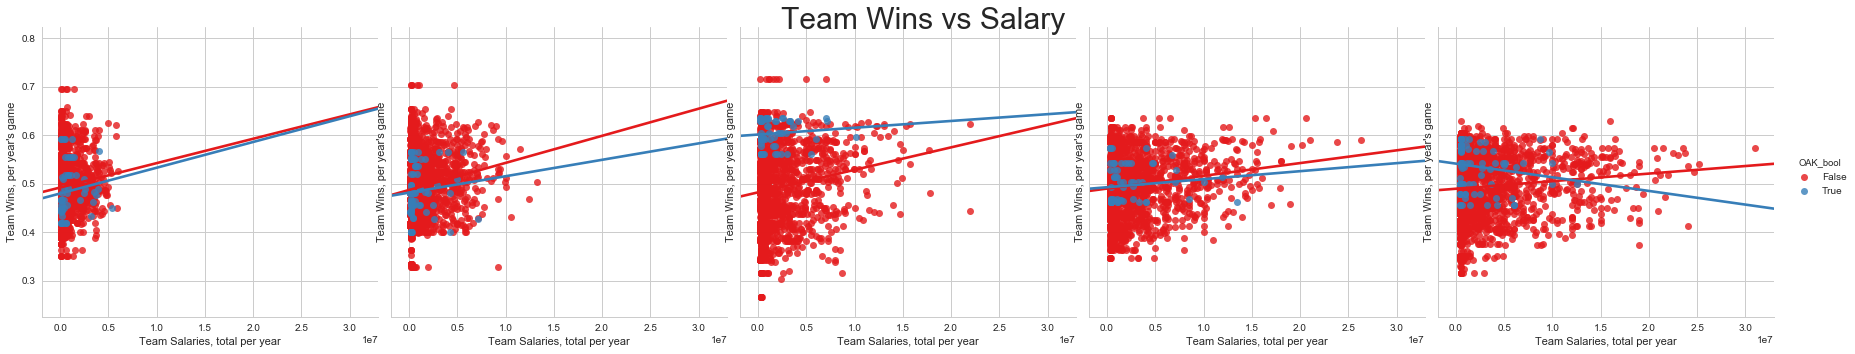

In [461]:
cut_df.OAKbool = cut_df.teamID == 'OAK'
cut_df['OAK_bool'] = cut_df.OAKbool

cut_df_OAK = cut_df[cut_df.teamID == 'OAK']
cut_df

t = 'Player Runs vs Salary' 
g = sns.lmplot('salary', 'R', data=cut_df, col='yearID', hue='OAK_bool',
           palette="Set1", ci=None)
g.set(ylim=(cut_df.R.min()*.85, cut_df.R.max()*1.15),
       title='')
g.set(xlabel='Player Salaries, total per year', 
       ylabel='Player Runs, total per year')
sns.plt.suptitle(t,fontsize=30)

t = 'Team Wins vs Salary' 
g = sns.lmplot('salary', 'WG_team', data=cut_df, col='yearID', hue='OAK_bool',
           palette="Set1", ci=None)
g.set(ylim=( cut_df.WG_team.min()*.85,  cut_df.WG_team.max()*1.15),
       title='')
g.set(xlabel='Team Salaries, total per year', 
       ylabel='Team Wins, per year\'s game')
sns.plt.suptitle(t,fontsize=30)

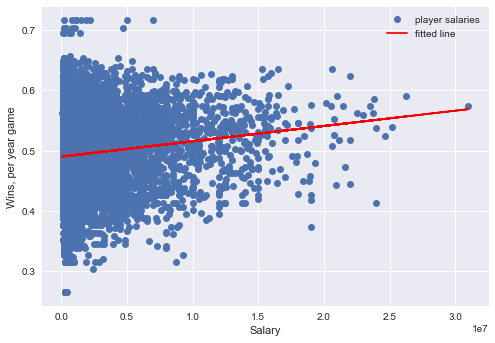

In [405]:
x = cut_df.salary
y = cut_df.WG_team
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
slope, r_value

plt.plot(x, y, 'o', label='player salaries')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')

plt.xlabel('Salaries, average team expense per year')
plt.ylabel('Wins, team per played game ratio')

plt.legend()
plt.xlabel('Salary')
plt.ylabel('Wins, per year game')
plt.show()

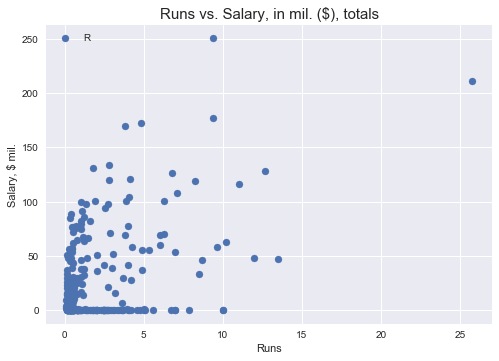

,playerID,yearID_avg,salary,RG,R,G,WG_team,W_team,G_team,OAK_bool
44,chaveer01,8019.000000,25.758000,1.821229,211.550000,396.850000,2.159110,349.400000,647.3,4.0
126,hollima01,2009.000000,13.500000,0.612903,47.000000,78.000000,0.462963,75.000000,162.0,1.0
152,kotsama01,4010.000000,12.666667,0.973218,128.666667,256.000000,1.090535,176.666667,324.0,2.0
148,kendaja01,2006.250000,11.945068,0.416639,47.750000,107.500000,0.513889,83.250000,162.0,1.0
180,mcgwima01,3989.666667,11.011667,1.246501,116.533333,189.533333,0.916686,142.533333,310.8,2.0
69,dyeje01,2003.000000,10.166667,0.543564,63.000000,111.000000,0.596708,96.666667,162.0,1.0
251,sheetbe01,2010.000000,10.000000,0.000000,0.000000,20.000000,0.500000,81.000000,162.0,1.0
140,johnsji04,2014.000000,10.000000,0.000000,0.000000,27.000000,0.543210,88.000000,162.0,1.0


In [402]:
sns.set()

players_df = cut_df_OAK.groupby('playerID').sum().reset_index().sort_values('salary', ascending=False)
players_df.salary = players_df.salary/1e6

plt.scatter(players_df.salary,players_df.R)

title = "Runs vs. Salary, in mil. ($), totals"
plt.title(title, fontsize=15)

plt.legend(loc='upper left', frameon=False)

plt.xlabel('Runs')
plt.ylabel('Salary, $ mil.')
plt.show()

players_df.head(8)

In [401]:
teams = np.unique(cut_df.teamID)
years = np.unique(cut_df.yearID)

#year_interval
# & (cut_df.yearID == year_interval)]

def reg(df, team):
    team_df = df[(cut_df.teamID == team)] 
    x = team_df.salary
    y = team_df.WG_team
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return slope, r_value

def reg_team(df, teams):
    d = dict()
    for i in range(len(teams)):
        d[teams[i]] = reg(df, teams[i])
    return pd.DataFrame(d).T.sort_values(0, ascending=False)

df1 = cut_df[cut_df.yearID == years[0]]
df2 = cut_df[cut_df.yearID == years[1]]
df3 = cut_df[cut_df.yearID == years[2]]
df4 = cut_df[cut_df.yearID == years[3]]
df5 = cut_df[cut_df.yearID == years[4]]

teams1 = np.unique(df1.teamID)
#df1 = reg_team(df1, teams1).sort_values(0, ascending=False).hist()

In [24]:
teams1 = np.unique(df2.teamID)
df2 = reg_team(df2, teams1).sort_values(0, ascending=False)

C:\Users\rockb\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [25]:
teams1 = np.unique(df3.teamID)
df3 = reg_team(df3, teams1).sort_values(0, ascending=False)

C:\Users\rockb\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [26]:
teams1 = np.unique(df4.teamID)
df4 = reg_team(df4, teams1).sort_values(0, ascending=False)

C:\Users\rockb\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [27]:
teams1 = np.unique(df5.teamID)
df5 = reg_team(df5, teams1).sort_values(0, ascending=False)

C:\Users\rockb\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


## Part 3: Data transformations

### Standardizing across years

It looks like comparing payrolls across years is problematic so let's do a transformation that will help with these comparisons.

#### Problem 5

Create a new variable in your dataset that standardizes payroll conditioned on year.

STANDARDIZED_PAYROLLij = (PAYROLLLij - AVG_PAYROLLj) / Sj

**code description:** standardized payrolls for teams and players. Merged with initial 'payroll' data frame updating it andand creatign a new 'team_avg_df' data frame for teams-level aggregates. 

________________________

#### Problem 6

Repeat the same plots as Problem 4, but use this new standardized payroll variable.

**code description:** reproduced problem 4 plots and plots with the new, standardized payroll variable below it. Plot sequence:
1. **team** runs  
 a. payroll  
 b. standardized payroll  
2. team wins  
 a. payroll  
 b. standardized payroll  



1. **player** runs  
 a. payroll  
 b. standardized payroll  
2. player wins  
 a. payroll  
 b. standardized payroll  

#### Q3: Discuss how the plots from Problem 4 and Problem 6 reflect the transformation you did on the payroll variable.

**A:** The figures in problem 4 & 6 explore actor spend to performance relationship: plots player and team salaries against their runs and wins in 5 year increments (1990-2015). 

Normalized salaries set all salaries on a comparable scale, allowing us to examine more meaningful differences between teams' salaries and performance. Now, any external differences year on year (e.g. inflation) have been taken into consideration. As a result, OAK's 2000 - 05' correlation is not as extreme after normalization. 

In [28]:
n_bins=5

yr = roster.reset_index().yearID
hist, bin_edges = np.histogram(yr.values,n_bins)
bin_edges = np.round_(bin_edges).astype(int)

mag_bins = pd.cut(roster.reset_index().yearID, bin_edges)
cut_df = roster.reset_index().groupby([mag_bins,'teamID','playerID']).mean().dropna()
cut_df.columns = ['yearID_avg', 'salary', 'RG', 'R', 'G', 'WG_team', 'W_team', 'G_team']
cut_df = cut_df.reset_index()

________________________

In [33]:
payroll.head()

salary  team_yr_salary_avg  team_yr_salary_sd  \
yearID teamID playerID                                                     
1990   ATL    bellmi01   100000.0       456858.606061      556071.744467   
              blausje01  180000.0       456858.606061      556071.744467   
              boevejo01  430000.0       456858.606061      556071.744467   
              castito02  100000.0       456858.606061      556071.744467   
              claryma01  125000.0       456858.606061      556071.744467   

                               RG     R    G   WG_team  W_team  G_team  \
yearID teamID playerID                                                   
1990   ATL    bellmi01   0.222222   8.0   36  0.401235      65     162   
              blausje01  0.400000  46.0  115  0.401235      65     162   
              boevejo01  0.000000   0.0   67  0.802469     130     324   
              castito02  0.019231   1.0   52  0.401235      65     162   
              claryma01  0.000000   0.0   33  0.401235      65     162   

                         player_salary_standardized  
yearID teamID playerID                               
1990   ATL    bellmi01                    -0.641749  
              blausje01                   -0.497883  
              boevejo01                   -0.048301  
              castito02                   -0.641749  
              claryma01                   -0.596791

__________________

### Teams

In [396]:
#team_avg_df = payroll.reset_index().groupby(['yearID','teamID']).mean()
payroll = roster.groupby(['yearID','teamID','playerID']).sum().reset_index().set_index('yearID')

avg_payroll = dict(roster.groupby(['yearID','teamID']).mean().salary)
sd_payroll = dict(roster.groupby(['yearID','teamID']).std().salary)

avg_sd_df = pd.DataFrame([avg_payroll, sd_payroll]).T
avg_sd_df.index = pd.MultiIndex.from_tuples(avg_sd_df.index)
avg_sd_df.index.names = ['yearID', 'teamID']
avg_sd_df.columns = ['team_yr_salary_avg', 'team_yr_salary_sd']

payroll = pd.merge(payroll.reset_index(),avg_sd_df.reset_index(),
         how='left',on=['yearID','teamID'])\
         [['teamID','yearID','playerID','salary', 'team_yr_salary_avg', 'team_yr_salary_sd',
          'RG', 'R', 'G', 'WG_team', 'W_team', 'G_team']]\
        .set_index(['yearID','teamID','playerID'])
#produce standardized payrolls, using these dfs:
    #salary
    #salary_avg
    #salary_sd
payroll['team_salary_standardized'] = (payroll.salary - payroll.team_yr_salary_avg) / payroll.team_yr_salary_sd

n_bins=5

yr = payroll.reset_index().yearID
hist, bin_edges = np.histogram(yr.values,n_bins)
bin_edges = np.round_(bin_edges).astype(int)

mag_bins = pd.cut(payroll.reset_index().yearID, bin_edges)
team_avg_df = payroll.reset_index().groupby([mag_bins,'teamID']).mean().dropna()
team_avg_df = team_avg_df[['salary','team_yr_salary_avg','team_yr_salary_sd','team_salary_standardized', 
                          'RG', 'R', 'G', 'WG_team', 'W_team', 'G_team']].reset_index()
team_avg_df

,yearID,teamID,salary,team_yr_salary_avg,team_yr_salary_sd,team_salary_standardized,RG,R,G,WG_team,W_team,G_team
0,"(1990, 1995]",ATL,1.311290e+06,1.251850e+06,1.375166e+06,0.047270,0.230374,21.676056,66.535211,0.641587,95.633803,156.253521
1,"(1990, 1995]",BAL,1.046511e+06,1.012456e+06,1.290741e+06,0.021207,0.342891,32.598039,79.666667,0.523791,78.441176,154.862745
2,"(1990, 1995]",BOS,1.132188e+06,1.059759e+06,1.231328e+06,0.057896,0.379856,34.968085,83.861702,0.551534,82.148936,160.085106
3,"(1990, 1995]",CAL,1.030939e+06,9.560414e+05,1.110660e+06,0.071365,0.383326,36.301075,85.354839,0.501703,75.591398,161.440860
4,"(1990, 1995]",CHA,1.369672e+06,1.310470e+06,1.321518e+06,0.037163,0.397922,41.102273,89.931818,0.563854,83.738636,155.647727
5,"(1990, 1995]",CHN,1.117501e+06,1.051323e+06,1.340642e+06,0.052344,0.216339,18.847222,62.354167,0.518050,77.062500,158.166667
6,"(1990, 1995]",CIN,1.361642e+06,1.294668e+06,1.445957e+06,0.051052,0.262462,22.911565,64.646259,0.553812,81.755102,157.061224
7,"(1990, 1995]",CLE,7.275678e+05,6.828072e+05,7.034456e+05,0.099083,0.416383,36.357895,80.378947,0.561583,82.357895,163.378947
8,"(1990, 1995]",COL,6.817995e+05,6.454335e+05,8.749088e+05,0.061223,0.233432,20.254902,58.088235,0.500232,70.656863,151.411765
9,"(1990, 1995]",DET,1.374026e+06,1.315360e+06,1.432854e+06,0.033865,0.360178,36.960396,82.594059,0.493739,74.128713,155.297030


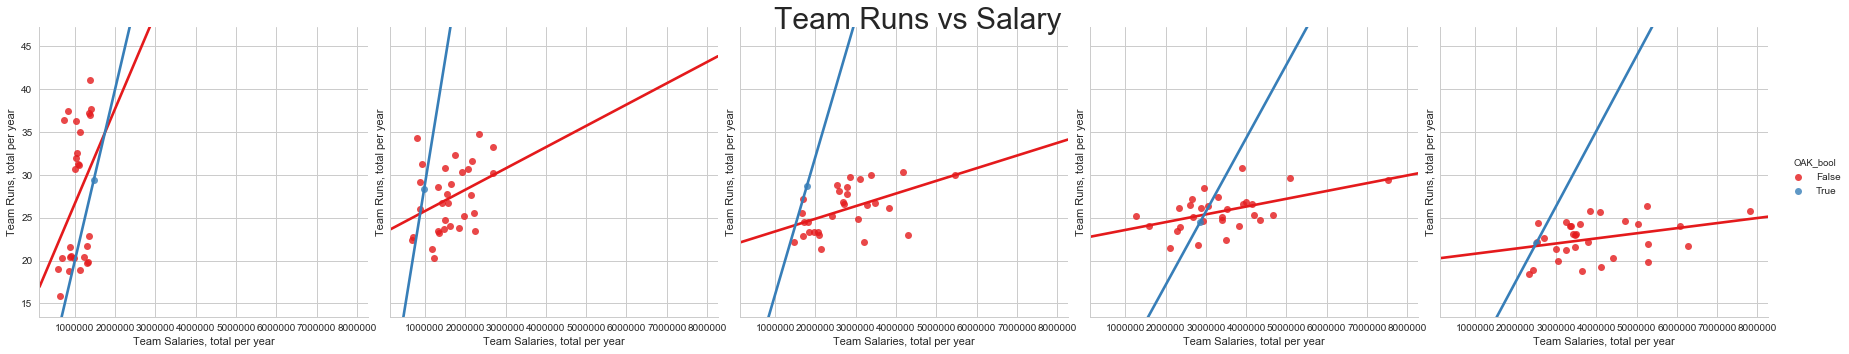

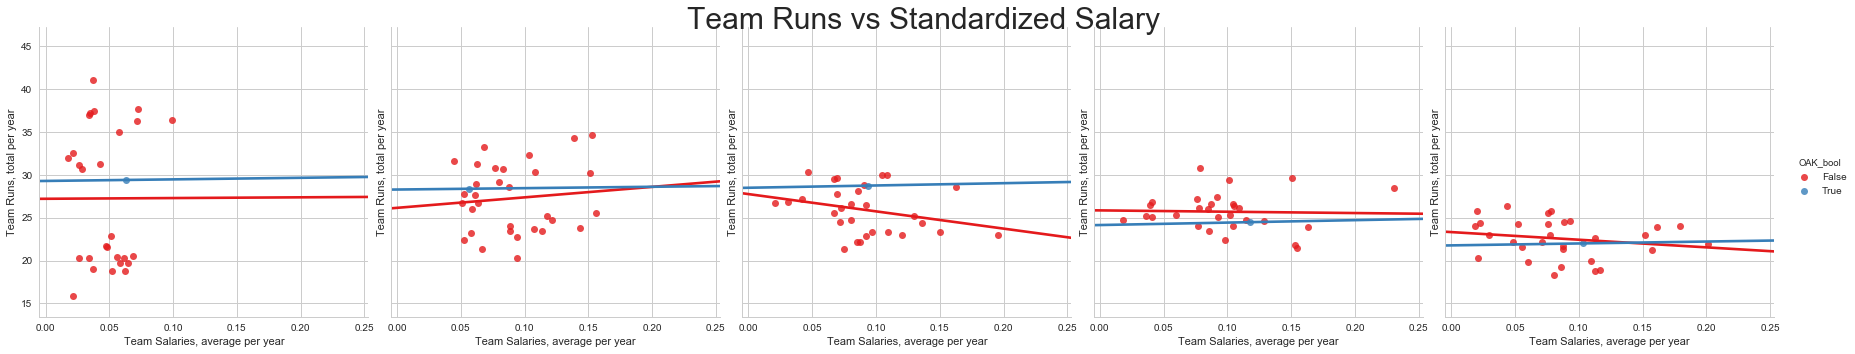

In [458]:
team_avg_df.OAKbool = team_avg_df.teamID == 'OAK'
team_avg_df['OAK_bool'] = team_avg_df.OAKbool

t = 'Team Runs vs Salary'
g = sns.lmplot('salary', 'R', data=team_avg_df, col='yearID', hue='OAK_bool',
           palette="Set1", ci=None)
g.set(ylim=(team_avg_df.R.min()*.85, team_avg_df.R.max()*1.15),
       title='')
g.set(xlabel='Team Salaries, total per year', 
       ylabel='Team Runs, total per year')
sns.plt.suptitle(t,fontsize=30)

t = 'Team Runs vs Standardized Salary'
g = sns.lmplot('team_salary_standardized', 'R', data=team_avg_df, col='yearID', hue='OAK_bool',
           palette="Set1", ci=None)
g.set(ylim=(team_avg_df.R.min()*.85, team_avg_df.R.max()*1.15),
       title='')
g.set(xlabel='Team Salaries, average per year', 
       ylabel='Team Runs, total per year')
sns.plt.suptitle(t,fontsize=30)


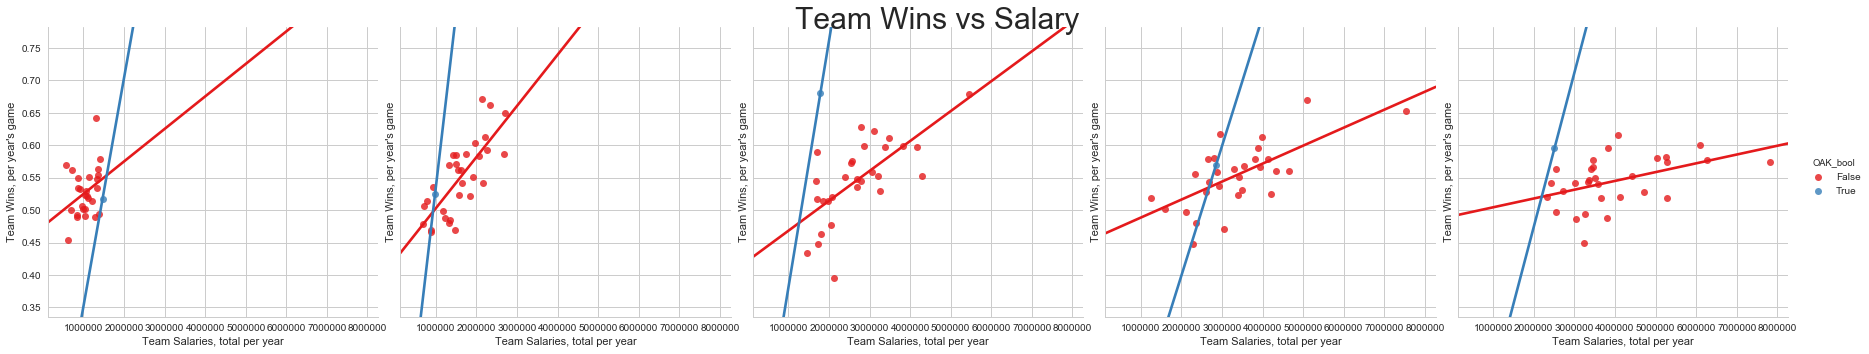

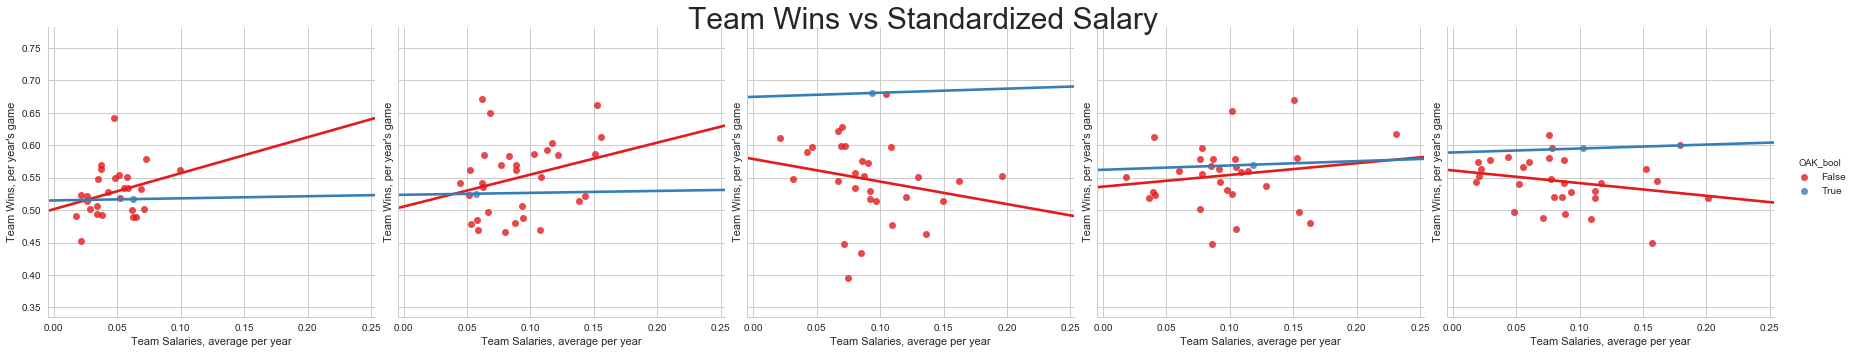

In [462]:
t = 'Team Wins vs Salary'
g = sns.lmplot('salary', 'WG_team', data=team_avg_df, col='yearID', hue='OAK_bool',
           palette="Set1", ci=None)
g.set(ylim=(team_avg_df.WG_team.min()*.85, team_avg_df.WG_team.max()*1.15),
       title='')
g.set(xlabel='Team Salaries, total per year', 
       ylabel='Team Wins, per year\'s game')
sns.plt.suptitle(t,fontsize=30)


t = 'Team Wins vs Standardized Salary'
g = sns.lmplot('team_salary_standardized', 'WG_team', data=team_avg_df, col='yearID', hue='OAK_bool',
           palette="Set1", ci=None)
g.set(ylim=(team_avg_df.WG_team.min()*.85, team_avg_df.WG_team.max()*1.15),
       title='')
g.set(xlabel='Team Salaries, average per year', 
       ylabel='Team Wins, per year\'s game')
sns.plt.suptitle(t,fontsize=30)

__________________

### Players
#### cut payroll_df

#### Standardized Payroll

In [108]:
avg_payroll_yr = roster.groupby(['yearID']).mean().salary
avg_payroll_team = roster.groupby(['yearID','teamID']).mean().salary
avg_payroll = avg_payroll_team.reset_index().salary.mean()

std_year = avg_payroll_team.reset_index().salary.std()

In [109]:
standardize = lambda Payroll_teaminyr: (Payroll_teaminyr - Payroll_yravg) / SD_yr

In [242]:
payroll = roster.groupby(['yearID','teamID','playerID']).sum().reset_index().set_index('yearID')

avg_payroll = dict(roster.groupby(['yearID','teamID']).mean().salary)
sd_payroll = dict(roster.groupby(['yearID','teamID']).std().salary)

avg_sd_df = pd.DataFrame([avg_payroll, sd_payroll]).T
avg_sd_df.index = pd.MultiIndex.from_tuples(avg_sd_df.index)
avg_sd_df.index.names = ['yearID', 'teamID']
avg_sd_df.columns = ['player_yr_salary_avg', 'player_yr_salary_sd']

payroll = pd.merge(payroll.reset_index(),avg_sd_df.reset_index(),
         how='left',on=['yearID','teamID'])\
         [['teamID','yearID','playerID','salary', 'player_yr_salary_avg', 'player_yr_salary_sd',
          'RG', 'R', 'G', 'WG_team', 'W_team', 'G_team']]\
        .set_index(['yearID','teamID','playerID'])
#produce standardized payrolls, using these dfs:
    #salary
    #salary_avg
    #salary_sd
payroll['player_salary_standardized'] = (payroll.salary - payroll.player_yr_salary_avg) / payroll.player_yr_salary_sd
payroll.head()

salary  player_yr_salary_avg  player_yr_salary_sd  \
yearID teamID playerID                                                         
1990   ATL    bellmi01   100000.0         456858.606061        556071.744467   
              blausje01  180000.0         456858.606061        556071.744467   
              boevejo01  430000.0         456858.606061        556071.744467   
              castito02  100000.0         456858.606061        556071.744467   
              claryma01  125000.0         456858.606061        556071.744467   

                               RG     R    G   WG_team  W_team  G_team  \
yearID teamID playerID                                                   
1990   ATL    bellmi01   0.222222   8.0   36  0.401235      65     162   
              blausje01  0.400000  46.0  115  0.401235      65     162   
              boevejo01  0.000000   0.0   67  0.802469     130     324   
              castito02  0.019231   1.0   52  0.401235      65     162   
              claryma01  0.000000   0.0   33  0.401235      65     162   

                         player_salary_standardized  
yearID teamID playerID                               
1990   ATL    bellmi01                    -0.641749  
              blausje01                   -0.497883  
              boevejo01                   -0.048301  
              castito02                   -0.641749  
              claryma01                   -0.596791

In [243]:
n_bins=5

yr = payroll.reset_index().yearID
hist, bin_edges = np.histogram(yr.values,n_bins)
bin_edges = np.round_(bin_edges).astype(int)

mag_bins = pd.cut(payroll.reset_index().yearID, bin_edges)
payroll_cut = payroll.reset_index().groupby([mag_bins,'teamID','playerID']).mean().dropna()
payroll_cut = payroll_cut[['salary','player_yr_salary_avg','player_yr_salary_sd','player_salary_standardized',
                          'RG', 'R', 'G', 'WG_team', 'W_team', 'G_team']].reset_index()

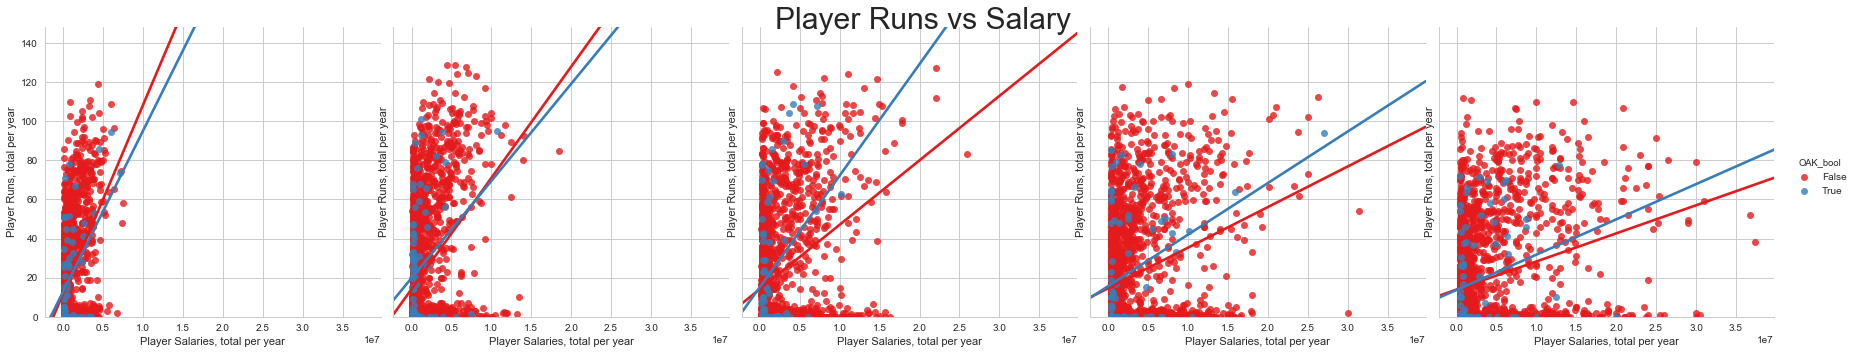

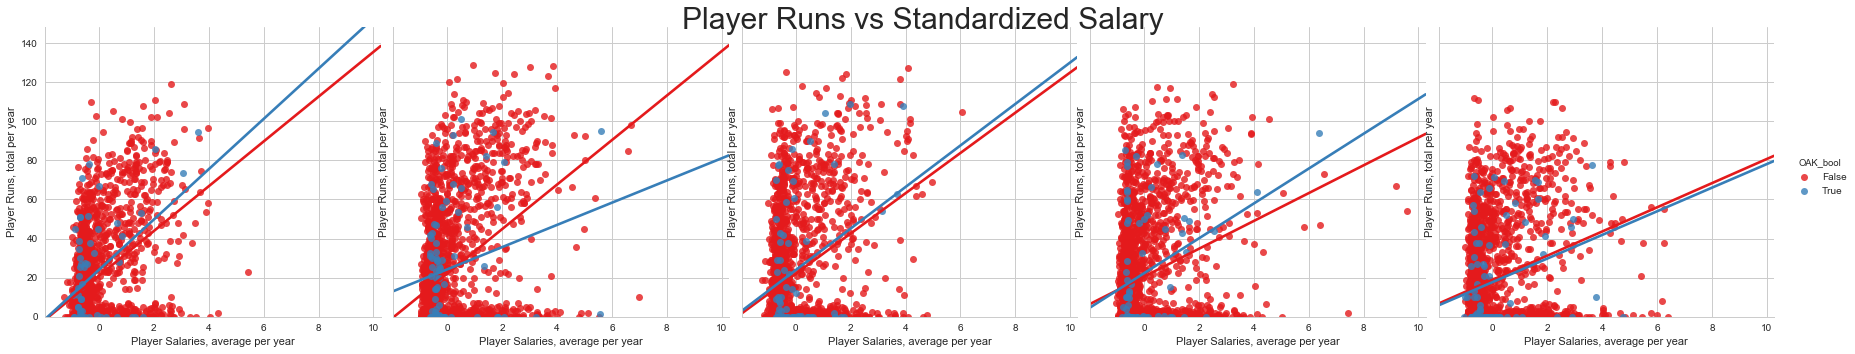

In [464]:
payroll_cut.OAKbool = payroll_cut.teamID == 'OAK'
payroll_cut['OAK_bool'] = payroll_cut.OAKbool

t = 'Player Runs vs Salary'
g = sns.lmplot('salary', 'R', data=payroll_cut, col='yearID', hue='OAK_bool',
           palette="Set1", ci=None)
g.set(ylim=(payroll_cut.R.min()*.85, payroll_cut.R.max()*1.15),
       title='')
g.set(xlabel='Player Salaries, total per year', 
       ylabel='Player Runs, total per year')
sns.plt.suptitle(t,fontsize=30)


t= 'Player Runs vs Standardized Salary' 
g = sns.lmplot('player_salary_standardized', 'R', data=payroll_cut, col='yearID', hue='OAK_bool',
           palette="Set1", ci=None)
g.set(ylim=(payroll_cut.R.min()*.85, payroll_cut.R.max()*1.15),
      title='')
g.set(xlabel='Player Salaries, average per year', 
       ylabel='Player Runs, total per year')
sns.plt.suptitle(t,fontsize=30)


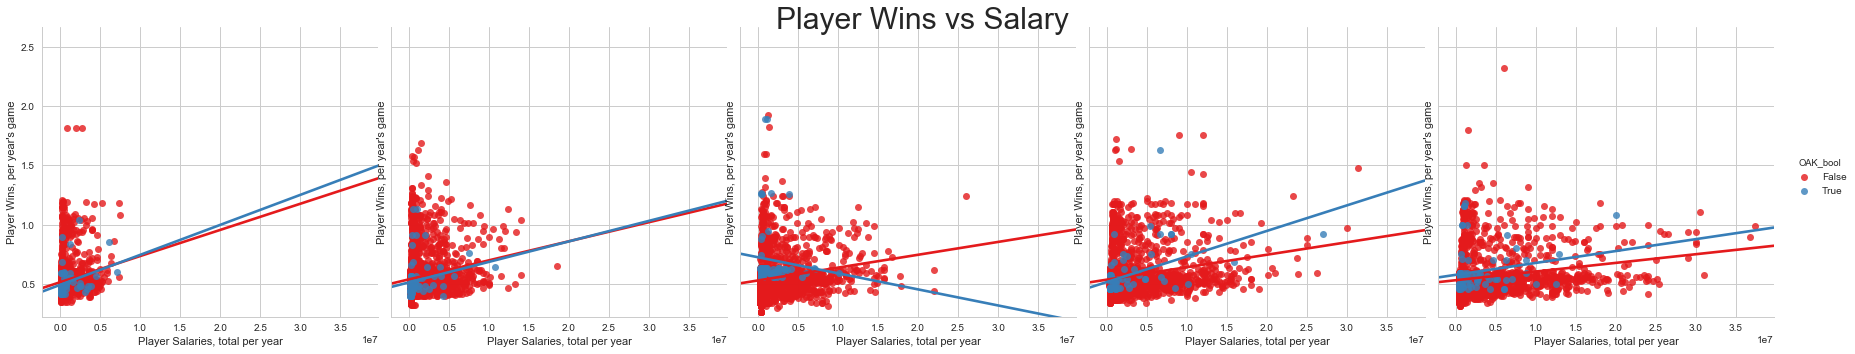

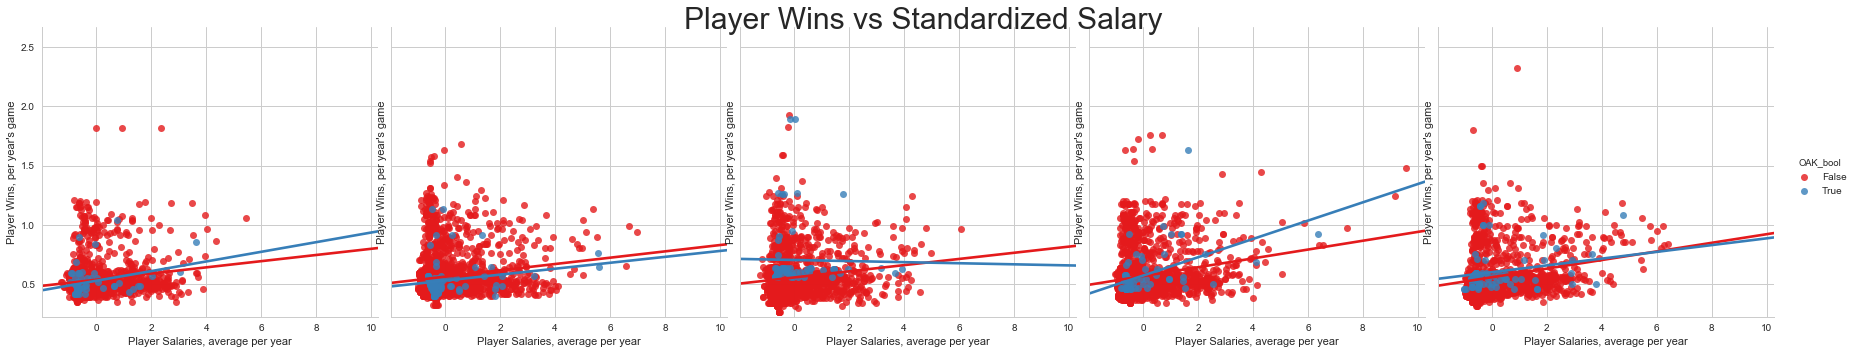

In [456]:
#Player Wins vs Salary
g = sns.lmplot('salary', 'WG_team', data=payroll_cut, col='yearID', hue='OAK_bool',
           palette="Set1", ci=None)
g.set(ylim=(payroll_cut.WG_team.min()*.85, payroll_cut.WG_team.max()*1.15))
g.set(xlabel='Player Salaries, total per year', 
       ylabel='Player Wins, per year\'s game',
     title='')
sns.plt.suptitle('Player Wins vs Salary',fontsize=30)

#Player Wins vs Standardized Salary
g = sns.lmplot('player_salary_standardized', 'WG_team', data=payroll_cut, col='yearID', hue='OAK_bool',
           palette="Set1", ci=None)
g.set(ylim=(payroll_cut.WG_team.min()*.85, payroll_cut.WG_team.max()*1.15),
           title='')
g.set(xlabel='Player Salaries, average per year', 
       ylabel='Player Wins, per year\'s game')
sns.plt.suptitle('Player Wins vs Standardized Salary',fontsize=30)

plt.show()

In [240]:
#note: team_avg_df merge payroll

### Expected wins

#### Problem 7
Make a single scatter plot of winning percentage (y-axis) vs. standardized payroll (x-axis). Add a regression line to highlight the relationship.

The regression line gives you expected winning percentage as a function of standardized payroll. Looking at the regression line, it looks like teams that spend roughly the average payroll in a given year will win 50% of their games (i.e. win\_pct is 50 when standardized\_payroll is 0), and teams increase 5% wins for every 2 standard units of payroll (i.e., win\_pct is 55 when standardized\_payroll is 2). We will see how this is done in general using linear regression later in the course.

Make a single scatter plot of winning percentage (y-axis) vs. standardized payroll (x-axis). Add a regression line to highlight the relationship.

**code description:** single plots of player salaries + regression line.

In [257]:
#x = standardized_payroll 
#y = winning_percentage
                      
#def scat(x,y):
#    plot(x,y)
#    add_reg
#    return fig

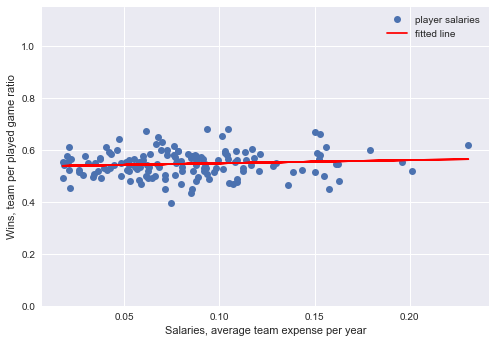

In [404]:
x = team_avg_df.team_salary_standardized
y = team_avg_df.WG_team

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
slope, r_value

plt.plot(x, y, 'o', label='player salaries')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.ylim(0,1.15)
plt.legend()

plt.xlabel('Salaries, average team expense per year')
plt.ylabel('Wins, team per played game ratio')
plt.show()

___________________________

### Spending efficiency

Using this result, we can now create a single plot that makes it easier to compare teams efficiency. The idea is to create a new measurement unit for each team based on their winning percentage and their expected winning percentage that we can plot across time summarizing how efficient each team is in their spending.

#### Problem 8

Create a new field to compute each team's spending effiency.  

**code description:** calculated team spending efficiency; made plots efficiency plots. 

In [263]:
#avg_wns = intercept + slope*x
expected_wns = 50 + 2.5 * team_avg_df.team_yr_salary_avg
win_pct = team_avg_df.WG_team
efficiency = win_pct - expected_wns
team_avg_df['team_efficiency'] = efficiency

year = team_avg_df.yearID 

Make a line plot with year on the x-axis and efficiency on the y-axis. A good set of teams to plot are Oakland, the New York Yankees, Boston, Atlanta and Tampa Bay (teamIDs OAK, BOS, NYA, ATL, TBA).

def lmplt(x,y):  
    return fig  

x = year   
y = efficiency  
lmplt(x,y)  

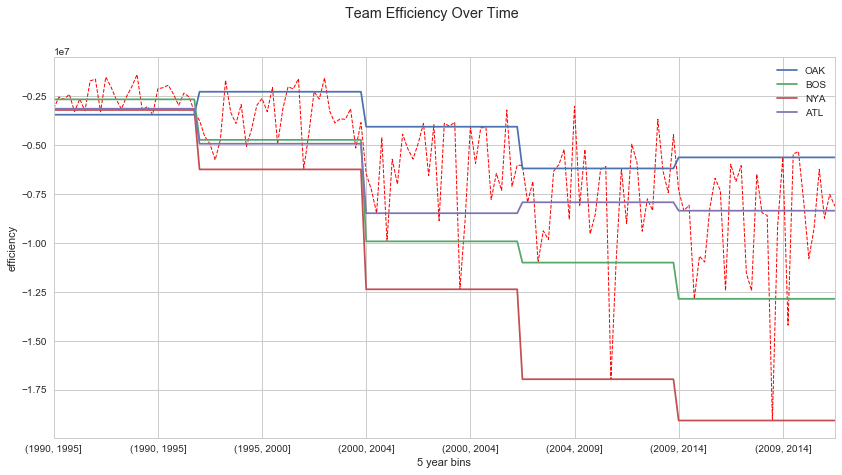

In [421]:
fig, axes = plt.subplots(nrows=1, ncols=1)

efficiency_df['team_efficiency'].plot(figsize=[14,7],style=['--'],c='r',lw=1,ax=axes); # axes[0,0].set_title('A');
efficiency_df[teamIDs_to_plot].plot(figsize=[14,7],ax=axes); # axes[0,0].set_title('B');

plt.suptitle('Team Efficiency Over Time')
plt.xlabel('5 year bins')
plt.ylabel('efficiency')
plt.show()

________

#### Q4: What can you learn from this plot compared to the set of plots you looked at in Question 2 and 3? How good was Oakland's efficiency during the Moneyball period? 

**A:** The Team Efficiency Over Time line plot shows differences between expected and actual win ratios trend over time for Oakland, the New York Yankees, Boston, Atlanta and all team averages (dashed). 

The line plot hilights efficiency trends over these time periods by team more clearly compared to previous plots because the lines plotted are based on aggregates. 

Oakland's efficiency during the Moneyball period was higher compared to these selected peers, consistently matching/near matching the higher side of all teams' efficiency averages. 